### __Question 1__

Run the container on your local machine, and write a Python script to make some requests to the container.<br>
Please provide:<br>
1. The code you use to make requests to the container<br>
2. After a few requests, what do you think the model does? Which inputs did you try and why?<br>

In [31]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# The container serves a HTTP API at http://localhost:8000
# Using the requests library it is possible to communicate with the API by making HTTP requests
# The API can be used to infer from a model
# Using the POST method it is possible to provide the model with an input, through the "json" parameter,
#   and to receive the corresponding output.
# The output is available accessing the attribute "text" of the Response object, in str type.
# The .json() method returns a JSON object of the result or, as in our case, a list.


url = 'http://localhost:8000'
numbers = list(np.linspace(-1,4, num=100))
myobj = {'numbers': numbers}

x = requests.post(url, json = myobj)

# A DataFrame with 2 columns is created: the "numbers" column is used to store the input numbers,
#   while the "output" column in used to store the output of the model.

df = pd.DataFrame(myobj)
df["output"] = pd.Series(x.json())
df.head()


,numbers,output
0,-1.000000,0.0
1,-0.949495,0.0
2,-0.898990,0.0
3,-0.848485,0.0
4,-0.797980,0.0


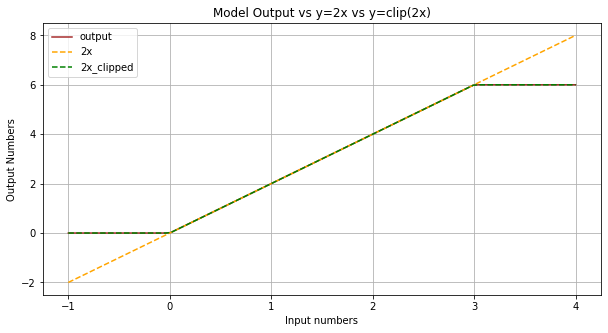

In [3]:
# In order to investigate the behavior of the model, its outputs have been analyzed
#   while giving different inputs (input-output analysis).
# Specifically the tried inputs were:
#   1) [1,2,3]
#   2) range(20)
#   3) [[1.,2.,3.],[1.,2.,3.]]              --> to understand what dimensionality of the input was accepted by the model
#   4) list(np.linspace(-10,10, num=100))   --> to understand the behavior with neg numbers
#   5) list(np.linspace(-1,4, num=100))     --> to understand the smoothness around the point at (0,0) and at (3,6)

# Using the same numbers previously given to the model,
#   2 fuctions are calculated and plotted against the model output.

# The 2 functions were chosen intuitively drawing conclusions from the previous I/O analysis. 
# The 2 fuctions are:
#   y = 2x 
#   y = clip(2x)

# This is done in order to visually show that the behavior of the model consists in applying to the inputs the
#   function y = clip(2x)


df["2x"] = 2*df.numbers
df["2x_clipped"] = np.clip(df["2x"],0,6)


cycler = plt.cycler(linestyle=['-', '--', '--'],color=['brown','orange', 'green'])
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler)
df.set_index("numbers").plot(ax=ax, xlabel="Input numbers", ylabel="Output Numbers", figsize=(10,5), title = "Model Output vs y=2x vs y=clip(2x)")
plt.grid(True)

## __Question 2__
Now that you are able to experiment with the model, you will need to extract<br>
the saved model from the container. The model is a TorchScript model.<br>
Please explain how you extracted the model from the running containers.<br>
Ideally you provide the exact commands or code used to achieve this.

Once the container is locally running, a terminal is opened inside the repository where this script is located.<br>
Below are listed the steps used to find the container id, to explore the files in the container, to find the TorchScript model and to copy it inside the repository.<br>

1) `docker container ls`                          --> lists all the active containers<br>
2) `docker exec -it <container_id> bash`        --> executes an interactive bash inside the container<br>
3) `ls`                                           --> lists files and folders in the pwd<br>
4) `CTRL + D`                                     --> exits the container interactive shell<br>
5) `docker cp <container_id>:\model_scripted.pt extracted_model`    --> copies the files at the container path into the destination path (repo where there is this code)

## __Question 3__
Now that you have extracted the model, you should inspect it locally.<br>
You should write Python code that:<br>
1. Loads the model<br>
2. Runs the model on the input [1.0, 2.0, 3.0]<br>
3. Inspects the layers of the model<br>
With this code, answer the following questions:<br>
• What does this model do? Do you think this is an useful model?<br>
• What is the advantage of saving models in the TorchScript format?<br>

In [7]:
import torch

In [8]:
# Model loading in eval() mode

with open("extracted_model.pt", "rb") as f:
    model = torch.jit.load(f)
model.eval()

RecursiveScriptModule(original_name=Model)

In [9]:
# Model running on the input [1,2,3]
cuda0 = torch.device('cuda:0')
input = torch.tensor([[1.,2.,3.],[1.,2.,3.],[1.,2.,3.]], device=cuda0)
output=model.forward(input)
print(output)

tensor([[2., 4., 6.],
        [2., 4., 6.],
        [2., 4., 6.]], device='cuda:0')


In [10]:
# Inspecting the code related to the layers of the model

print(model.code)

def forward(self,
    x: Tensor) -> Tensor:
  _0 = __torch__.torch.nn.functional.relu6(torch.mul(x, 2), False, )
  return _0



• What does this model do? Do you think this is an useful model?<br>

From the cell above it is possible to notice that the only layer used in this model is<br>
__torch.nn.functional.relu6__ where the input gets multiplied by 2 (torch.mul(x, 2)), behaving exactly like `y = clip(2x)`.<br>

Further info can be found on the online documentation:<br>
https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html#torch.nn.ReLU6<br>

This, probably, is not an useful model since it only applies an activation function to the inputs.<br>
Applying a threshold to the outputs (interpretable as a shifted unit step), the model could be interpreted as a classifier.<br>

• What is the advantage of saving models in the TorchScript format?<br>

The advantages of saving models in the TorchScript format can be summarized in __portability__ and __performace__.
TorchScript is a way to create serializable and optimizable models from PyTorch code. Any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency, for example C++, via LibTorch. For production scenarios, C++ is very often the language of choice and this approach allows you to embed your DL models in various production environments like mobile or IoT.
In order to do that, jit, an optimized compiler for PyTorch programs, has to be used. Moreover, jit should be used aslo if you want to gain some execution performance at the price of extra development effort: on CPU the runtimes are similar but on GPU TorchScript clearly outperforms PyTorch.

## Question 4
Now we want to integrate the model you extracted into a new scoring model.<br>
You should write Python code that creates a model satisfying the following<br>
requirements:<br>
• The new model is a Torch module (torch.nn.Module)<br>
• The new model takes two tensor inputs<br>
• The new model applies the extracted model to both tensor inputs to generate a “score” for both inputs<br>
• The new model then outputs a probability (between 0 and 1) that the first input is better than the second<br>
You do not need to export this model, just provide the code to instantiate it.

In [16]:
# Probability that the first input is better score than the second:
#   probability that randomly picking a score from the first tensor, it is greater than
#   a randomly picked score from the second tensor.


# Mann-Whitney U Test 
#
# Given two independent samples, it tests whether one variable tends to have values higher than the other.
# One form of the test statistic is an estimate of the probability that one variable is less than the other.
# 
# + Assumptions:
#       1) two indipendent random samples
#       2) ordinal scaled characteristics (scoring 0-6)

# + The Mann-Whitney U test results in:
#       - Null hypothesis: There is no difference between the two groups in the population
#       - Alternative hypothesis: There is a difference between the two groups in the population

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import mannwhitneyu as mw

class NewModel(nn.Module):

    def __init__(self, extracted_model):
        super(NewModel, self).__init__()
        self.extracted_model = extracted_model
    def forward(self, x1, x2):
        y1 = self.extracted_model.forward(x1).reshape((x1.numel(),1))
        y2 = self.extracted_model.forward(x2).reshape((x2.numel(),1))
        y = mw(y1, y2, alternative="greater").statistic/(len(y1)*len(y2))        
        return y

In [28]:
with open("extracted_model.pt", "rb") as f:
    model = torch.jit.load(f)
model.eval()


# Test 1: 
# The two tensors are part of the same distribution
# Expected probability ~ 0.5
# 
a = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))
b = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))
print(NewModel(model).forward(a,b))

# Test 2: 
# The first tensor and the second are the same
# Expected probability = 0.5
# 
a = torch.tensor(np.random.uniform(-10,10,(20000,10,10)))

print(NewModel(model).forward(a,a))


# Test 3: 
# First tensor is always greater
# Expected probability = 1.0
#
a = torch.tensor(np.zeros(10000)+3)
b = torch.tensor(np.zeros(10000))
print(NewModel(model).forward(a,b))

# Test 4: 
# Second tensor is always greater
# Expected probability = 0.0
#
a = torch.tensor(np.zeros(10000))
b = torch.tensor(np.zeros(10000)+3)
print(NewModel(model).forward(a,b))

# Test 5:
# The two tensors are identical except for the last element that is greater in the first tensor
# Expected probability = 0.1
#

a = torch.cat((torch.tensor(np.zeros(9)), torch.tensor(np.zeros(1)+8)))
b = torch.cat((torch.tensor(np.zeros(9)), torch.tensor(np.zeros(1))))
print(NewModel(model).forward(a,b))




[0.49958837]
[0.5]
[1.]
[0.]
[0.55]


In [24]:
torch.cat((torch.tensor(np.zeros(1)), torch.tensor(np.zeros(1)+8)))

tensor([0., 8.], dtype=torch.float64)

In [29]:
a

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 8.], dtype=torch.float64)

In [30]:
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)